# EMT MADRID - MobilityLabs API
The docs of the API can be found here:
https://apidocs.emtmadrid.es/

To start using the API, it is necessary to register an account with an email and a password that allow us to login and get an access token, we can do that in the following website:
https://mobilitylabs.emtmadrid.es/

We also have access to some examples and the source code of the api in the following link: https://gitlab.com/mobilitylabsmadrid

The following notebook gives a simple idea of how to use the main methods of the API, but there are more available that can be found in the docs.

In [3]:
#First we import the requested modules
import pandas as pd #Module for the dataframes
import geopandas as gpd #For the geodataframes
import requests 
import json
from shapely.geometry import Point, LineString
from shapely.geometry import shape
from shapely import wkt
import fiona
import asyncio
from concurrent.futures import ThreadPoolExecutor
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

#We use this to plot the graphics below the line when calling plot()
%matplotlib inline

#Function to ensure we get a good response for the request
def requests_retry_session(retries=3,backoff_factor=0.3,status_forcelist=(500, 502, 504),session=None):
    session = session or requests.Session()
    retry = Retry(
        total=retries,
        read=retries,
        connect=retries,
        backoff_factor=backoff_factor,
        status_forcelist=status_forcelist,
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    return session

## Start session in the API
Once we have our account, we can login and get an accessToken with the following method:

In [4]:
#Our access credentials
email = 'p.parker230220@gmail.com'
password = 'CkBLZvmg5Jg&pej64$'
email = 'alejarabo@gmail.com'
password = 'YXKE8fDrX.pMZ58'

#We make the request for the login, in order to get the access token
response = requests_retry_session().get(
    'https://openapi.emtmadrid.es/v2/mobilitylabs/user/login/',
    headers={
        'email':email,
        'password':password
    },
    timeout=5
)

#We transform the response to json
json_response = response.json()
json_response

{'code': '00',
 'description': 'Register user: alejarabo with token: 742055d7-6bde-4b43-b112-9f6be0be8016 ',
 'datetime': '2020-03-03T20:33:14.974039',
 'data': [{'updatedAt': '2020-02-24T08:40:49.7200000',
   'username': 'alejarabo',
   'accessToken': '742055d7-6bde-4b43-b112-9f6be0be8016',
   'tokenSecExpiration': 86400,
   'email': 'alejarabo@gmail.com',
   'idUser': '9e44cabc-d4bd-4cc7-bbc4-89ae4f8adaf5',
   'apiCounter': {'current': 0,
    'dailyUse': 20000,
    'owner': 0,
    'licenceUse': 'Please mention EMT Madrid MobilityLabs as data source. Thank you and enjoy!',
    'aboutUses': 'If you need to extend the daily use of this API, please, register your App in Mobilitylabs and use your own X-ClientId and  passKey instead of generic login (more info in https://mobilitylabs.emtmadrid.es/doc/new-app and https://apidocs.emtmadrid.es/#api-Block_1_User_identity-login)'},
   'nameApp': 'OPENAPI MobilityLabs',
   'priv': 'U'}]}

In [5]:
#We get the access token from the json and print it
accessToken = json_response['data'][0]['accessToken']
accessToken

'742055d7-6bde-4b43-b112-9f6be0be8016'

## Get the stops that belong to a line and a direction
Calling the following method we get the stops that a bus passes through when it goes through the specified line and direction

In [6]:
lineId = '1' #We want to get the stops for the line with id=1
direction = '1' #In the direction 1
response = requests_retry_session().get(
    'https://openapi.emtmadrid.es/v2/transport/busemtmad/lines/{}/stops/{}/'.format(lineId,direction),
    headers = {'accessToken': accessToken}
)

#We turn the response into a json and show the result of the request
line_stops = response.json()['data'][0]
line_stops

{'line': '001',
 'label': '1',
 'stops': [{'stop': '4514',
   'name': 'Cristo Rey',
   'postalAddress': 'Isaac Peral, frente al Nº 40.',
   'geometry': {'type': 'Point',
    'coordinates': [-3.71793052606063, 40.4384746558032]},
   'pmv': '61748',
   'dataLine': ['001', '044', '069', '082', '132']},
  {'stop': '4022',
   'name': 'Junta Municipal Moncloa',
   'postalAddress': 'Isaac Peral frente al Nº 8',
   'geometry': {'type': 'Point',
    'coordinates': [-3.71842134613126, 40.4358409821157]},
   'pmv': '61745',
   'dataLine': ['001', '044', '062', '069', '082', '132', '138', '521']},
  {'stop': '3687',
   'name': 'Moncloa',
   'postalAddress': 'Arcipreste de Hita con C/ Fernando el Catolico',
   'geometry': {'type': 'Point',
    'coordinates': [-3.7180849386363, 40.4341403665582]},
   'pmv': '61225',
   'dataLine': ['001', '044', '062', '069', '138', '521']},
  {'stop': '737',
   'name': 'Altamirano',
   'postalAddress': 'Princesa, 75',
   'geometry': {'type': 'Point',
    'coordinat

## Information about buses that are going to arrive a certain stop
With this method we can get a lot information about the buses that are going to arrive a stop, such as the ETA, the distance, the bus id and much more. We have to send a json in the data of the request to specify if we want to get or not information about the stop, the incidents and the estimations. If we dont specify the line we want to get the information about, it returns us the information about all the lines that pass through this stop.

In [7]:
#We get the id for the first stop of the line 1
stopId = line_stops['stops'][0]['stop']

#We construct the body for the request
body = {
    'cultureInfo': 'EN',
    'Text_StopRequired_YN': 'Y',
    'Text_EstimationsRequired_YN': 'Y',
    'Text_IncidencesRequired_YN': 'Y',
    'DateTime_Referenced_Incidencies_YYYYMMDD':'20200130'
}

#And we turn it into a json object
body = json.dumps(body)
body

'{"cultureInfo": "EN", "Text_StopRequired_YN": "Y", "Text_EstimationsRequired_YN": "Y", "Text_IncidencesRequired_YN": "Y", "DateTime_Referenced_Incidencies_YYYYMMDD": "20200130"}'

In [9]:
import re
import datetime
#And once we have all the attributes for the request ready, we perform it like this:
response = requests_retry_session().post(
    'https://openapi.emtmadrid.es/v2/transport/busemtmad/stops/{}/arrives/{}/'.format('162','1'),
    data = body,
    headers = {
        'accessToken': accessToken,
        'Content-Type': 'application/json' #We specify that we are doing an application with a json object
    },
    timeout = 5
)

#And we show the data returned by the request
response.status_code
arrival_data = response.json()
arrival_data['data'][0]

{'Arrive': [{'line': '1',
   'stop': '162',
   'isHead': 'False',
   'destination': 'PROSPERIDAD',
   'deviation': 0,
   'bus': 121,
   'geometry': {'type': 'Point',
    'coordinates': [-3.7074286195654644, 40.420308063471396]},
   'estimateArrive': 311,
   'DistanceBus': 879,
   'positionTypeBus': '0'},
  {'line': '1',
   'stop': '162',
   'isHead': 'False',
   'destination': 'PROSPERIDAD',
   'deviation': 0,
   'bus': 123,
   'geometry': {'type': 'Point',
    'coordinates': [-3.7169400270534414, 40.437461784139984]},
   'estimateArrive': 1425,
   'DistanceBus': 3104,
   'positionTypeBus': '0'}],
 'StopInfo': [{'lines': [{'label': '1',
     'line': '001',
     'nameA': 'CRISTO REY',
     'nameB': 'PROSPERIDAD',
     'metersFromHeader': 3979,
     'to': 'B',
     'color': '0072ce'}],
   'stopId': '162',
   'stopName': 'Retiro',
   'geometry': {'type': 'Point',
    'coordinates': [-3.68826031065316, 40.4196998317684]},
   'Direction': 'Pza. de la Independencia (Retiro)                  

In [47]:
(4+1)%5

0

In [48]:
list = [Point(0,0),Point(0,0)]
list[1].x

0.0

## Obtain collections of data
We can also get collections of data from the API, the collections available are shown in the following link:
https://mobilitylabs.emtmadrid.es/es/portal/collections 

In order to get the data of the desired collection, we have to get its collection id from the site above, and then call the following method

In [19]:
#We request the collection of Madrid Central Area, that has this id
collection_id = 'b94ea072-77ca-433d-adce-b3504f3abd00'

#And we perform the request
response = requests_retry_session().post(
    'https://openapi.emtmadrid.es/v1/mobilitylabs/collection/reactive/{}/1/'.format(collection_id),
    headers = {
        'accessToken': accessToken,
        'Content-Type': 'application/json'
    },
    data = {},
    timeout = 5
)

#We show the result of the request
response.text

'{"code": "90", "description": "Error in API process Expecting value: line 1 column 1 (char 0)", "datetime": "2020-02-23T18:50:35.307465", "data": []}'

## Load static dataframes with the lines and the stops
For interacting with the data we have about the stops and the lines, we have constructed the two dataframes shown below from the information given in the gtfs (an standard for transit datafiles created by Google) of the EMT Madrid for urban buses(M6). This process is shown in this other notebook:

Both of this dataframes have a 'geometry' column, which contains Point objects for the location of the stops, and LineString objects for the lines. The presence of this column is the main difference between geodataframes and dataframes, but both of them have the same methods for interacting with them

In [20]:
#We load the stop's data
stops = gpd.read_file('M6/stops.json')
#With head() we show the first five columns of the dataframe
stops.head()

,stop_code,stop_name,stop_desc,zone_id,location_type,parent_station,wheelchair_boarding,geometry
0,161,Puerta de Alcalá,Plaza de la Independencia 3,A,0,None,2,POINT (-3.68919 40.42069)
1,162,Retiro,Avda de Méjico SN,A,0,None,2,POINT (-3.68826 40.41970)
2,164,Círculo de Bellas Artes,Calle Gran Vía 3,A,0,None,2,POINT (-3.69715 40.41896)
3,168,Santo Domingo,Calle Gran Vía 56,A,0,None,2,POINT (-3.70761 40.42159)
4,169,Santo Domingo,Calle Gran Vía 47,A,0,None,2,POINT (-3.70746 40.42114)


In [21]:
#And we load the line's data
route_lines = gpd.read_file('M6Data/route_lines.json')
route_lines.head()

,itinerary_id,line_id,direction,orig_dist,dist,geometry
0,6_N_501____1__IT_1,501,1,84.910,20.429,"LINESTRING (-3.69234 40.41997, -3.69193 40.420..."
1,6_N_501____2__IT_1,501,2,42.932,13.472,"LINESTRING (-3.64667 40.48592, -3.64668 40.485..."
2,6_N_502____1__IT_1,502,1,60.927,19.403,"LINESTRING (-3.69269 40.41872, -3.69269 40.418..."
3,6_N_502____2__IT_1,502,2,96.684,21.195,"LINESTRING (-3.61127 40.49814, -3.61091 40.498..."
4,6_N_503____1__IT_1,503,1,31.595,14.011,"LINESTRING (-3.69269 40.41872, -3.69269 40.418..."


## Get point that is at a certain distance on a LineString from a given point 
When we call the method for the information about a stop, it returns us the distance of this buses to the stop, but not the coordinates of them (it returns [0,0]). This method transforms the distance of the bus to the stop into the coordinates that correspond to going back along the line 'distance' meters.

In [22]:
def point_by_distance_on_line (line, line_lenght, distance, origin_point) :
    """
    Returns the coordinates of the bus location

        Parameters
        ----------
        line : LineString
            The line that the bus belongs to
        line_length : float
            The length of the line
        distance : float
            The distance of the bus to the stop in kilometers
        origin_point : Point
            The location of the bus stop
    """
    
    #First we calculate the normalized distance of the bus from the start of the line
    #by substracting the distance of the bus to the stop to the distance of the stop to the start of the line
    #which is returned by the project method of the shapely module
    normalized_distance = line.project(origin_point,normalized=True) - distance/line_lenght
    
    #Then we get the the coordinates of the point that is at the normalized distance obtained 
    #before from the start of the line with the interpolate method
    interpolated_point = line.interpolate(normalized_distance,normalized=True)
    
    #And we return the coordinates of the point
    return (interpolated_point.x,interpolated_point.y)

## Create dictionary with stops for each line and direction
In order to make some methods faster, we build a dictionary that contains the stop codes and locations in an array for each line and direction.

In [32]:
def get_stops_of_line(lineId,direction,accessToken) :
    """
    Returns the list of stops for the line and direction desired

        Parameters
        ----------
        lineId : string
            The line id
        direction : string
            The direction (1 or 2)
        accessToken: string
            The accessToken obtained in the login
    """
    
    response = requests_retry_session().get(
        'https://openapi.emtmadrid.es/v2/transport/busemtmad/lines/{}/stops/{}/'.format(lineId,direction),
        headers = {'accessToken': accessToken},
        timeout = 5
    )
    
    #We turn the data of the stops from the response into a dataframe
    stops_data = pd.DataFrame(response.json()['data'][0]['stops'])   
    #And transform the geometry coordinates into point objects
    stops_data['geometry'] = [shape(i) for i in stops_data['geometry']]
    return stops_data

#We construct the dictionary
with open('M6Data/line_stops_dict.json', 'r') as f:
    line_stops_dict = json.load(f)
#line_stops_dict = {}
#If we want to build the dictionary for all the stops we uncomment this (takes about 45min):
line_ids = route_lines['line_id'].unique() 
#In order to make the example faster we just get the data for two lines
#line_ids = ['1','2']
for lineId in line_ids:   
    if lineId not in line_stops_dict :
        line_stops_dict[lineId] = {}
    for direction in route_lines['direction'].unique(): 
        #For each line and direction we get the stops data and put it inside the dict
        try:
            if direction not in line_stops_dict[lineId] :
                line_stops_dict[lineId][direction] = {}
            if 'stops' in line_stops_dict[lineId][direction] :
                pass
            else :
                stops_data = get_stops_of_line(lineId,direction,accessToken)
                line_stops_dict[lineId][direction] = {
                    'stops' : stops_data['stop'].tolist()
                }     
        except :
            pass

#We save the new dict
with open('M6Data/line_stops_dict.json', 'w') as fp:
    json.dump(line_stops_dict, fp)
#We print the dictionary
line_stops_dict

{'501': {'1': {'stops': ['72',
    '72',
    '65',
    '66',
    '66',
    '62',
    '60',
    '5333',
    '532',
    '430',
    '432',
    '418',
    '416',
    '414',
    '515',
    '439',
    '112',
    '115',
    '117',
    '210',
    '214',
    '497',
    '501',
    '503',
    '505',
    '507',
    '508',
    '3250',
    '3248',
    '3246',
    '5661',
    '5404',
    '5405',
    '5657',
    '5409',
    '3603',
    '3605',
    '3607',
    '5423',
    '5425',
    '4220',
    '4221',
    '5397',
    '5399',
    '5401']},
  '2': {'stops': ['5401',
    '5398',
    '5402',
    '5403',
    '139',
    '137',
    '4935',
    '513',
    '498',
    '1836',
    '211',
    '116',
    '114',
    '4831',
    '440',
    '438',
    '436',
    '441',
    '442',
    '443',
    '444',
    '446',
    '57',
    '59',
    '61',
    '63',
    '5626',
    '72',
    '72']}},
 '502': {'1': {'stops': ['5727',
    '162',
    '751',
    '2227',
    '2229',
    '2231',
    '2233',
    '2235',
    '2009',
    '

In [27]:
line_stops_dict.keys()

dict_keys(['501', '502', '503', '504', '505', '506', '507', '508', '509', '510', '511', '512', '513', '514', '515', '516', '517', '518', '519', '520', '521', '522', '523', '524', '525', '526', '527', '528', '057', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '1', '11', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '12', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '14', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '15', '151', '152', '153', '155', '156', '160', '16', '162', '165', '166', '17', '171', '172', '173', '174', '175', '176', '177', '178', '180', '18', '19', '2', '200', '20', '203', '21', '215', '22', '23', '24', '25', '26', '27', '28', '29', '30', '3', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '401', '402', '403', '404', '4', '41', '42', '43', '44', '45', '451', '452', '453', '454', '455', '4

## Get data of arrival data for all the buses in the line
This function returns the data of all the buses of the line, including the position, into a dataframe. Its main purpose is to build live representations that show the movement of all the buses in the line on the map of Madrid.

In [11]:
def get_arrival_times(lineId,stopId,accessToken) :
    """
    Returns the arrival data of buses for the desired stop and line

        Parameters
        ----------
        lineId : string
            The line id
        stopId : string
            The stop code
        accessToken: string
            The accessToken obtained in the login
    """
    
    #We build the body for the request
    body = {
        'cultureInfo': 'ES',
        'Text_StopRequired_YN': 'Y',
        'Text_EstimationsRequired_YN': 'Y',
        'Text_IncidencesRequired_YN': 'N',
        'DateTime_Referenced_Incidencies_YYYYMMDD':'20200130'
    }
    
     #And we perform the request
    response = requests_retry_session().post(
        'https://openapi.emtmadrid.es/v2/transport/busemtmad/stops/{}/arrives/{}/'.format(stopId,lineId),
        data = json.dumps(body),
        headers = {
            'accessToken': accessToken,
            'Content-Type': 'application/json'
        },
        timeout = 5
    )
    
    #We turn the data into a json and return the arrival data and the coordinates of the stop that made the call
    response_json = response.json()
    arrival_data = response_json['data'][0]['Arrive']
    stop_coords = Point(response_json['data'][0]['StopInfo'][0]['geometry']['coordinates'])
    return [arrival_data,stopId,stop_coords]

In [12]:
def get_arrival_time_data_of_line(lineId,line1,line2,stops_dir1,stops_dir2,accessToken) :
    """
    Returns the data of all the buses inside the desired line

        Parameters
        ----------
        lineId : string
            The line id
        line1 : DataFrame row
            Data about the line in direction 1
        line2 : DataFrame row
            Data about the line in direction 2
        stops_dir1 : list
            The list of the stops for direction 1
        stops_dir2 : list
            The list of the stops for direction 2
        accessToken: string
            The accessToken obtained in the login
    """
    #We get the LineString object and length from the rows
    line1_geom = line1['geometry']
    line1_length = line1['dist']
    line2_geom = line2['geometry']
    line2_length = line2['dist']

    #The keys for the dataframe that is going to be built
    keys = ['bus','line','stop','isHead','destination','deviation','estimateArrive','DistanceBus']
    
    #List with all the stops in both directions
    stop_codes = stops_dir1 + stops_dir2
    
    #Function to perform the requests asynchronously, performing them concurrently would be too slow
    async def get_data_asynchronous() :
        row_list = []
        points_list = []
        
        #We set the number of workers that is going to take care about the requests
        with ThreadPoolExecutor(max_workers=10) as executor:
            #We create a loop object
            loop = asyncio.get_event_loop()
            #And a list of tasks to be performed by the loop
            tasks = [
                loop.run_in_executor(
                    executor,
                    get_arrival_times, #Function that is gonna be called by the tasks
                    *(lineId,stopId,accessToken)  #Parameters for the function
                )
                for stopId in stop_codes
            ]
            #And finally we perform the tasks and gather the information returned by them into two lists
            for arrival_data in await asyncio.gather(*tasks) :
                arrival_times = arrival_data[0]
                stop_id = arrival_data[1]
                stop_coords = arrival_data[2]
                for bus in arrival_times :
                    values = [bus[key] for key in keys]
                    row_list.append(dict(zip(keys, values)))
                    #We calculate the bus position depending on the direction it belongs to
                    if stop_id in stops_dir1 :
                        points_list.append(Point(point_by_distance_on_line(line1_geom,line1_length,bus['DistanceBus']/1000,stop_coords)))
                    else :
                        points_list.append(Point(point_by_distance_on_line(line2_geom,line2_length,bus['DistanceBus']/1000,stop_coords)))
        return [row_list,points_list]
    
    #We declare the loop and call it, then we run it until it is complete
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    future = asyncio.ensure_future(get_data_asynchronous())
    loop.run_until_complete(future)

    #And once it is completed we gather the information returned by it like this
    row_list = future.result()[0]
    points_list = future.result()[1]
    
    #We create the dataframe of the buses
    buses_gdf = pd.DataFrame(row_list, columns=keys)
    buses_gdf['geometry'] = points_list
    
    #And then we get only the rows where each bus is closer to a stop (lower DistanceBus attrib)
    frames = []
    for busId in buses_gdf['bus'].unique() :
        buses_gdf_reduced = buses_gdf.loc[(buses_gdf['bus']==busId)]
        frames.append(buses_gdf_reduced.loc[buses_gdf_reduced['DistanceBus']==buses_gdf_reduced['DistanceBus'].min()])

    buses_gdf_unique = pd.concat(frames)
    
    #Finally we return the geodataframe
    return gpd.GeoDataFrame(buses_gdf_unique,crs=fiona.crs.from_epsg(4326),geometry='geometry')

In [13]:
#We get the stops of the line from the dict
stops_dir1 = line_stops_dict[lineId]['1']['stops']
stops_dir2 = line_stops_dict[lineId]['2']['stops']

#And the line rows
lineId = '1'
line1 = route_lines.loc[(route_lines['line_id']==lineId)&(route_lines['direction']=='1')]
line2 = route_lines.loc[(route_lines['line_id']==lineId)&(route_lines['direction']=='2')]

#We call the method and see the resulting dataframe
arrival_time_data_of_line = get_arrival_time_data_of_line(lineId,line1,line2,stops_dir1,stops_dir2,accessToken) 
arrival_time_data_of_line.head()

ValueError: loop argument must agree with Future

In [14]:
#We can plot the bus points like this
arrival_time_data_of_line.plot()

NameError: name 'arrival_time_data_of_line' is not defined

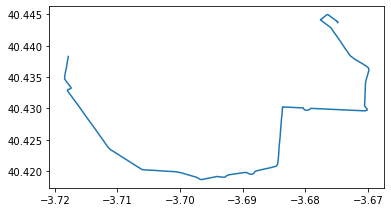

In [15]:
#And the shape of the line (direction 1) the buses are following
line1.plot()